# Jeu de données MNIST : CNN et méthode KMeans

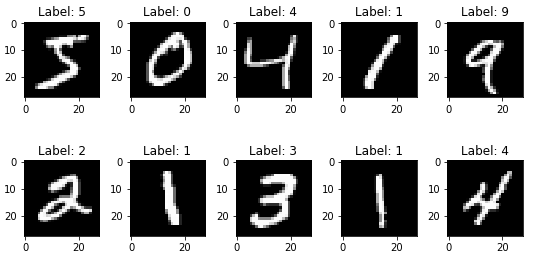

In [2]:
# Importing libraries
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

Dans un premier temps, nous allons tester les CNN car nous pensons obtenir de meilleurs résultats avec cette méthode. 

En effet, cette méthode est plus évoluée et adaptée pour notre situation. Nous nous justifierons plus en détail sur ce choix à la fin de ce document.

In [5]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape the data to have a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Convert the data to float32 and normalize it
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Convert the labels to categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# We remove the max pooling layer because it reduces the accuracy, even if it is faster
# model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback to save the best model
checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Fit the model
res = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the model
model.save('model.h5')

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1875/1875 [==============================] - 74s 39ms/step - loss: 0.1219 - accuracy: 0.9640 - val_loss: 0.0559 - val_accuracy: 0.9831
Epoch 2/5
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0447 - accuracy: 0.9861 - val_loss: 0.0365 - val_accuracy: 0.9885
Epoch 3/5
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0261 - accuracy: 0.9916 - val_loss: 0.0444 - val_accuracy: 0.9868
Epoch 4/5
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.0428 - val_accuracy: 0.9877
Epoch 5/5
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0506 - val_accuracy: 0.9865
Test loss: 0.05061403289437294
Test accuracy: 0.9865000247955322


Comme nous l'avions prévu, nous obtenons rapidement une précision très élevée. Nous avons cependant effectué quelques modifications et traitements pour maximiser nos performances : 

Traitement en amont des données : les images de l'ensemble de données MNIST sont des images en niveaux de gris 28x28 et doivent être prétraitées pour pouvoir être introduites dans le CNN. Les images sont remodelées en tableaux de forme (28, 28, 1), mises à l'échelle à des valeurs comprises entre 0 et 1.

Les différentes couches de notre modèle : la première couche est une couche Conv2D qui effectue des opérations de convolution sur l'image d'entrée pour extraire des caractéristiques. Ensuite, nous avons dans un premier temps essayer d'intégrer une couche MaxPooling2D pour éventuellement réduire les dimensions spatiales des feature maps. Cependant, cela réduisant légérement nos performances, nous l'avons retirer de notre modèle. A la place, nous avons ajouté une seconde couche Conv2D et une couche Flatten afin d'aplatir les feature maps en un vecteur unique. La dernière couche est une couche dense (Dense) qui effectue la classification.

Nous compilons ensuite le modèle et le sauvegardons pour éventuellement pouvoir le réutiliser plus tard.

Afin de pouvoir prouver l'efficacité de notre modèle, nous allons afficher les valeurs de notre précision de test et d'entrainement en fonction des épochs sous forme de graphique. 

Même chose pour notre loss.

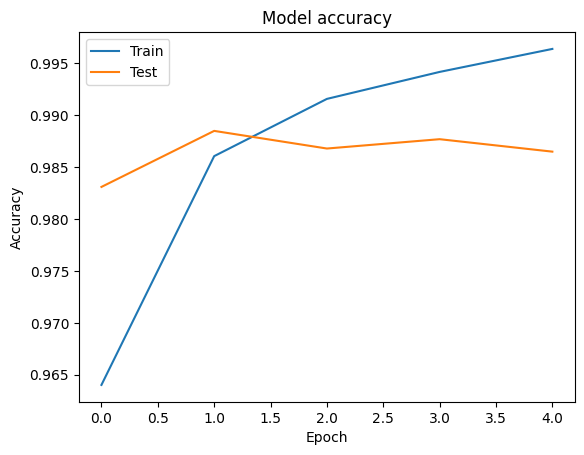

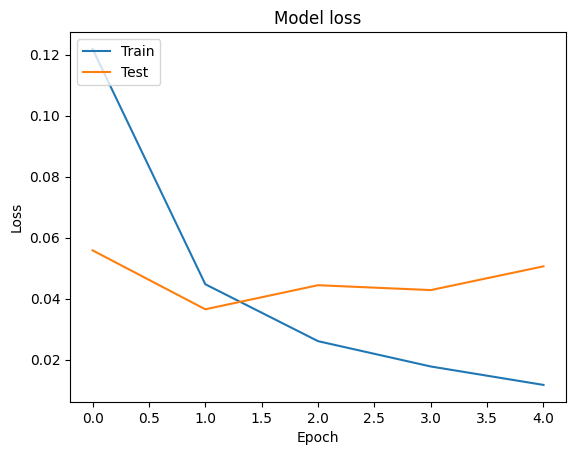

In [6]:
# Plot model statistics
plt.plot(res.history['accuracy'])
# Got error: KeyError: 'acc'

plt.plot(res.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot model statistics
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Nous pouvons également afficher notre F1 score et notre matrice de confusion :

In [7]:
# Use the model to make predictions on the X_test data
predictions = model.predict(X_test)

# Convert the predictions to the class with the highest probability
prediction_classes = np.argmax(predictions, axis=1)

# Print the first 10 predictions
print("Prediction classes: ", prediction_classes[:10])

# Print the first 10 true labels
print("True labels: ", np.argmax(y_test[:10], axis=1))

# Print f1 score
print("F1 score: ", f1_score(np.argmax(y_test, axis=1), prediction_classes, average='macro'))

# Print confusion matrix
print("Confusion matrix: ", confusion_matrix(np.argmax(y_test, axis=1), prediction_classes))

313/313 [==============================] - 2s 7ms/step
Prediction classes:  [7 2 1 0 4 1 4 9 5 9]
True labels:  [7 2 1 0 4 1 4 9 5 9]
F1 score:  0.9864336417541579
Confusion matrix:  [[ 977    0    1    1    0    0    0    0    1    0]
 [   0 1128    2    2    1    0    0    1    1    0]
 [   0    1 1015    4    4    0    0    5    3    0]
 [   0    0    0 1006    0    3    0    0    1    0]
 [   2    0    1    0  973    0    0    0    0    6]
 [   0    0    0   11    0  879    1    0    1    0]
 [  12    2    0    3    5    5  931    0    0    0]
 [   0    6    9    1    1    0    0 1006    2    3]
 [   3    0    1    0    0    1    0    1  967    1]
 [   0    2    1    4    7    3    0    3    6  983]]


Suite à cela, nous devions tout de même essayer de battre notre performance obtenue avec les CNN. 

Nous avons alors choisi arbitrairement une des méthodes parmi celles proposées dans l'enoncé : la méthode KMeans. C'est une méthode que nous avions déjà employée par le passé pour d'autres problèmes et qui est très connu dans le monde du Machine Learning.

In [3]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the images
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Apply PCA to reduce the dimensionality of the data
# Increase slightly the accuracy
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit KMeans on the PCA-transformed data to get cluster assignments
kmeans = KMeans(n_clusters=50, random_state=42).fit(X_train_pca)

# Get the cluster assignments for the PCA-transformed training and test data
train_clusters = kmeans.predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

# Train an SVM classifier on the cluster assignments
svm = SVC(kernel='rbf', C=50, random_state=42).fit(train_clusters.reshape(-1, 1), y_train)

# Make predictions on the test data using the SVM classifier
predictions = svm.predict(test_clusters.reshape(-1, 1))

# Print the accuracy of the predictions
print("Accuracy: ", np.mean(predictions == y_test))

C:\Users\fabie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy:  0.5314


Pour tenter de maximiser notre précision, nous avons tout d'abord mis en place une technique statistique largement utilisée en Machine Learning : le PCA.
Il s'agit d'une méthode de réduction de la dimensionnalité qui transforme un ensemble de variables corrélées en un ensemble plus petit de variables non corrélées, appelées composantes principales, qui capturent la plupart de la variance des données d'origine. Cette technique nous a permit d'améliorer légérement notre score.

Nous avons également fait varier plusieurs paramètres et tester plusieurs valeurs pour chacune d'elles. Voici les plus notables et ce que l'on en a retenu : 
- Nombre de composantes de la fonction PCA : celui-ci détermine le nombre de composantes principales qui seront générées à partir des données originales. Plus le nombre de composantes est élevé, plus la variance des données est conservée, mais plus la dimensionnalité des données augmente. Un nombre inférieur de composantes signifie que moins de variance dans les données sera conservée, mais aussi que la dimensionnalité des données diminuera.

- Nombre de clusters dans KMeans : celui-ci détermine le nombre de clusters dans lesquels les données seront divisées. Un nombre plus élevé de clusters signifie que les données seront divisées en sous-groupes plus fins, tandis qu'un nombre plus faible de clusters signifie que les données seront divisées en sous-groupes plus grossiers.

- Kernel de la fonction SVM : celui-ci détermine la manière dont les données seront transformées dans un espace de dimension supérieure avant d'être classées. Différents kernels sont utilisés pour traiter différents types de données et sont sélectionnés en fonction du type de données et du problème à résoudre. Les kernels les plus couramment utilisés sont les suivants : linéaire, polynomial, fonction de base radiale (RBF) et sigmoïde. Dans notre cas, nous avons utilisé la fonction RBF car nous obtenions de meilleurs scores avec.

- Paramètre C de la fonction SVM : celui-ci contrôle le compromis entre l'obtention d'une faible erreur de formation et d'une faible erreur de test. Une valeur plus faible de C entraîne une marge plus large et une erreur d'apprentissage plus faible, mais peut entraîner une erreur de test plus élevée. Une valeur plus élevée de C se traduira par une marge plus étroite et une erreur de test plus faible, mais peut entraîner une erreur de formation plus élevée.

Cependant, nous n'avons pas réussi à obtenir un score satisfaisant (maximum de 0.53) et nous sommes même loin du score obtenu par les CNN (0.98)
La précision inférieure de la méthode KMeans par rapport aux CNN est probablement due à plusieurs facteurs :

- La représentation des caractéristiques : KMeans est une méthode de clustering, qui regroupe des points de données similaires et représente chaque cluster par son centroïde. Cette représentation des données peut ne pas rendre compte des relations complexes entre les pixels d'une image, ce qui peut conduire à une précision moindre. En revanche, les CNN sont spécifiquement conçus pour la classification d'images et utilisent des couches convolutives pour apprendre et extraire des caractéristiques de haut niveau des données d'image.

- Capacité du modèle : KMeans est une méthode simple et rapide, mais sa capacité à modéliser des relations complexes dans les données est limitée. Les SVM, bien que plus sophistiqués que KMeans, ne sont pas toujours en mesure de capturer toutes les informations pertinentes dans les données. En comparaison, les CNN ont une capacité de modélisation beaucoup plus grande et peuvent apprendre à représenter des relations beaucoup plus complexes dans les données.

- Régularisation : L'overfitting est un problème courant dans les modèles d'apprentissage profond et peut conduire à de mauvaises performances de généralisation. Les CNN disposent de techniques de régularisation intégrées, telles que le dropout, qui peuvent empêcher le surajustement et aider le modèle à mieux se généraliser aux nouvelles données.

Pour le jeu de données MNIST, nous en concluons alors que les CNN sont supérieurs à la méthode Kmeans.